In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from models import Model

/Users/I551393/Library/Caches/pypoetry/virtualenvs/tsf-ss25-timegpt-9SjHUXw4-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Undestanding

In [3]:
df = pd.read_csv('../../transformed_data/cleaned_australian_electricity_demand.csv')
df['ts'] = pd.to_datetime(df['ts'])
df = df.sort_values('ts').reset_index(drop=True)
df.rename(columns={"series_value": "y"}, inplace=True)
print("Length of the df: ", len(df))

Length of the df:  230736


6923


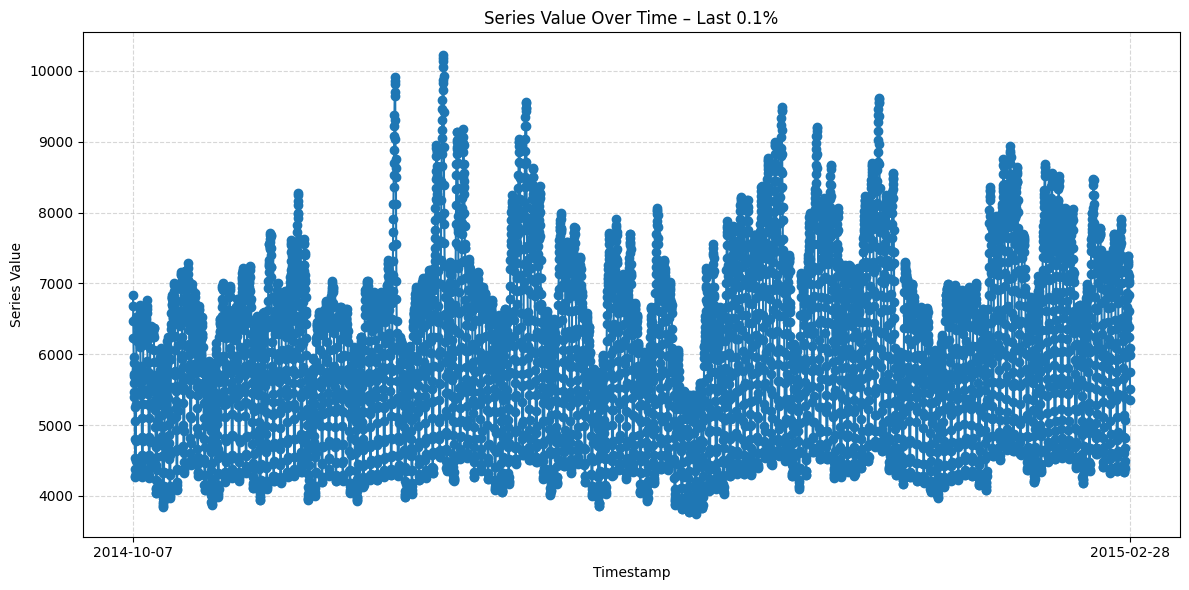

In [4]:
df_short = df[int(len(df) * 0.97):]
print(len(df_short))

start = df_short['ts'].min()
end = df_short['ts'].max()


plt.figure(figsize=(12, 6))
plt.plot(df_short['ts'], df_short['y'], marker='o')

# Start and End-Ticks
plt.xticks([start, end], [start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')])

plt.xlabel('Timestamp')
plt.ylabel('Series Value')
plt.title('Series Value Over Time – Last 0.1%')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [5]:
# shortening the dataset
df_recent = df.tail(1000).copy()
train_ratio = 0.8
split_idx   = int(len(df_recent) * train_ratio)

df_train = df_recent.iloc[:split_idx].copy().reset_index(drop=True)
df_test  = df_recent.iloc[split_idx:].copy().reset_index(drop=True)

print("Duplicates:", df_recent.duplicated().sum())
print("NaNs:\n", df_recent.isna().sum())
print("Frequency check:", df_recent.diff().dropna().value_counts().head())
df_recent.head()

Duplicates: 0
NaNs:
 ts    0
y     0
dtype: int64
Frequency check: ts               y          
0 days 00:30:00  -386.048922    1
                  68.288204     1
                  63.578102     1
                  63.715582     1
                  64.847014     1
Name: count, dtype: int64


,ts,y
229736,2015-02-08 04:00:00,4133.529452
229737,2015-02-08 04:30:00,4187.386448
229738,2015-02-08 05:00:00,4275.112720
229739,2015-02-08 05:30:00,4348.995946
229740,2015-02-08 06:00:00,4560.512158


In [6]:
df_recent['ts'].diff().dropna().value_counts()

ts
0 days 00:30:00    999
Name: count, dtype: int64

In [7]:
model = Model(df=df_recent)

✅ All timestamps are in a 30-minute grid


# Baseline Model

# ARIMA

In [8]:
arima_result = model.auto_arima()

Starting ARIMA Training...

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  800
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 48)   Log Likelihood               -3979.475
Date:                             Wed, 02 Jul 2025   AIC                           7966.950
Time:                                     17:28:54   BIC                           7985.436
Sample:                                          0   HQIC                          7974.073
                                             - 800                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7339      0.023     31.623      0.000       0.688       0.779

In [9]:
arima_result.tail()

,ts,yhat
195,2015-02-28 21:30:00,5532.577228
196,2015-02-28 22:00:00,5398.115737
197,2015-02-28 22:30:00,5212.204415
198,2015-02-28 23:00:00,5004.060864
199,2015-02-28 23:30:00,4843.667642


# LSTM

# Prophet

In [10]:
# Forecast
model = Model(df_recent)
prophet_result = model.prophet()
prophet_result.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp1i6bve5u/4ggklqrm.json
DEBUG:cmdstanpy:input tempfile: /var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp1i6bve5u/x6ipug86.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/I551393/Library/Caches/pypoetry/virtualenvs/tsf-ss25-timegpt-9SjHUXw4-py3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95922', 'data', 'file=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp1i6bve5u/4ggklqrm.json', 'init=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp1i6bve5u/x6ipug86.json', 'output', 'file=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp1i6bve5u/prophet_modelpvmubm19/prophet_model-20250702172854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:54 - cmdstanpy - INFO - Chain [1] sta

Prophet Training duration:  0.11786293983459473


,ts,yhat
0,2015-02-24 20:00:00,7049.889074
1,2015-02-24 20:30:00,6871.186489
2,2015-02-24 21:00:00,6693.789454
3,2015-02-24 21:30:00,6517.231438
4,2015-02-24 22:00:00,6338.477245


# TimesFM

# TimeGPT

In [11]:
model = Model(df_recent)
nixtla_result = model.time_gpt()

INFO:nixtla.nixtla_client:Happy Forecasting! :)
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


True
DF Train:  Index(['ts', 'y'], dtype='object')


INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Nixtla Prediction Time:  1.0465068817138672


In [12]:
nixtla_result.head()

,ts,yhat
0,2015-02-24 20:00:00,6823.503
1,2015-02-24 20:30:00,6735.766
2,2015-02-24 21:00:00,6656.076
3,2015-02-24 21:30:00,6586.825
4,2015-02-24 22:00:00,6549.632


# Summary

In [13]:
# Calculate metrics for all models
models_metrics = {}

# ARIMA metrics
arima_mae = mean_absolute_error(df_test['y'], arima_result['yhat'])
arima_mape = mean_absolute_percentage_error(df_test['y'], arima_result['yhat'])
arima_mse = mean_squared_error(df_test['y'], arima_result['yhat'])
models_metrics['ARIMA'] = {'MAE': arima_mae, 'MAPE': arima_mape, 'MSE': arima_mse}

# Prophet metrics
prophet_mae = mean_absolute_error(df_test['y'], prophet_result['yhat'])
prophet_mape = mean_absolute_percentage_error(df_test['y'], prophet_result['yhat'])
prophet_mse = mean_squared_error(df_test['y'], prophet_result['yhat'])
models_metrics['Prophet'] = {'MAE': prophet_mae, 'MAPE': prophet_mape, 'MSE': prophet_mse}

# TimeGPT metrics
nixtla_mae = mean_absolute_error(df_test['y'], nixtla_result['yhat'])
nixtla_mape = mean_absolute_percentage_error(df_test['y'], nixtla_result['yhat'])
nixtla_mse = mean_squared_error(df_test['y'], nixtla_result['yhat'])
models_metrics['TimeGPT'] = {'MAE': nixtla_mae, 'MAPE': nixtla_mape, 'MSE': nixtla_mse}

# Display results
metrics_df = pd.DataFrame(models_metrics).T
print("Model Performance Metrics:")
print(metrics_df.round(4))

Model Performance Metrics:
              MAE    MAPE           MSE
ARIMA    283.6021  0.0460  1.254444e+05
Prophet  326.1597  0.0526  1.701888e+05
TimeGPT  894.6087  0.1593  1.152736e+06


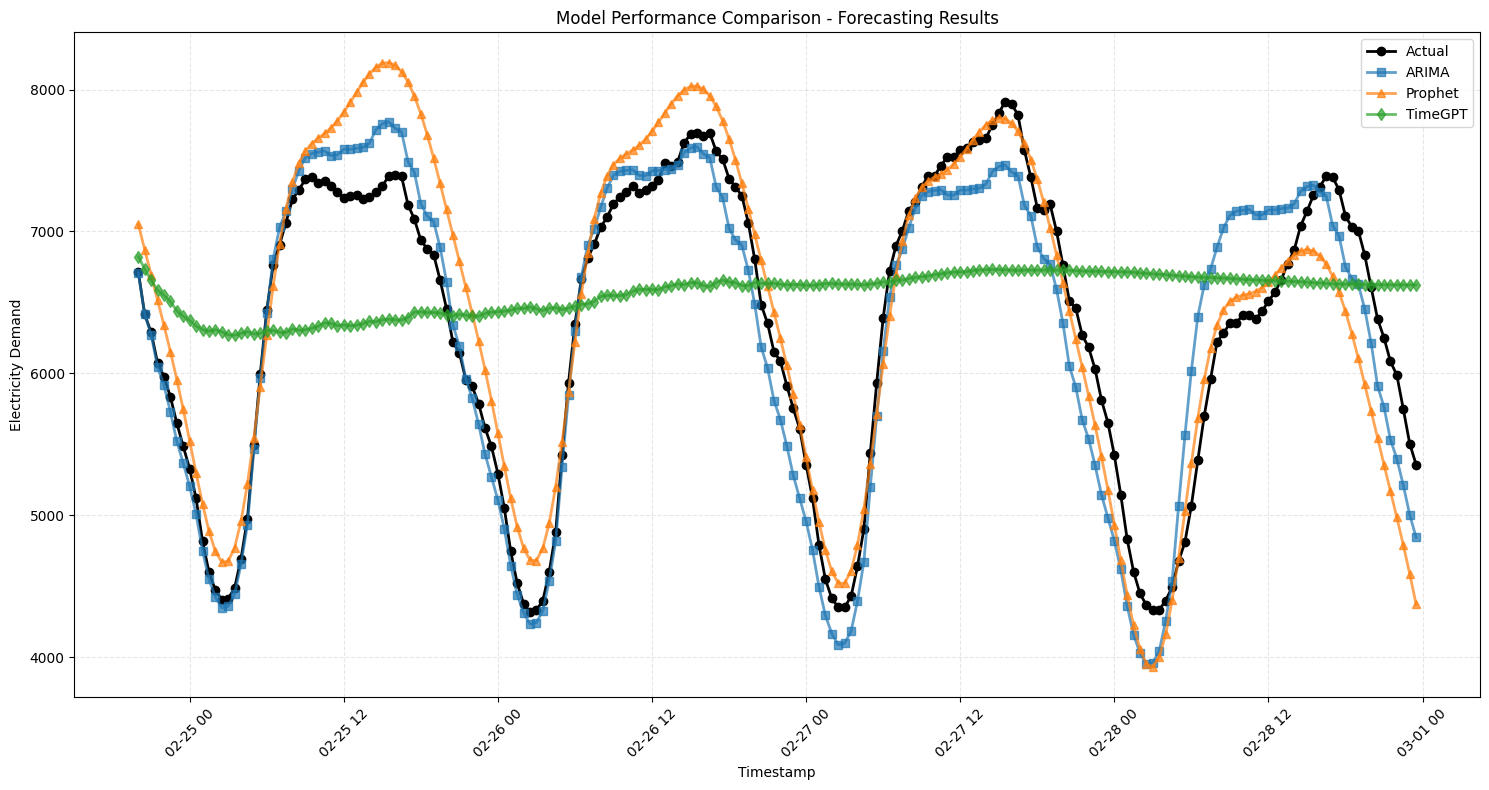

In [14]:
plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(df_test['ts'], df_test['y'], label='Actual', marker='o', linewidth=2, color='black')

# Plot ARIMA predictions (filter out NaN values)
arima_valid = arima_result.dropna()
plt.plot(arima_valid['ts'], arima_valid['yhat'], label='ARIMA', marker='s', linewidth=2, alpha=0.7)

# Plot Prophet predictions
plt.plot(prophet_result['ts'], prophet_result['yhat'], label='Prophet', marker='^', linewidth=2, alpha=0.7)

# Plot TimeGPT predictions
plt.plot(nixtla_result['ts'], nixtla_result['yhat'], label='TimeGPT', marker='d', linewidth=2, alpha=0.7)

plt.xlabel('Timestamp')
plt.ylabel('Electricity Demand')
plt.title('Model Performance Comparison - Forecasting Results')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()